In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import wandb

In [2]:
class UniformPermutations:
    def __init__(self, options):
        if type(options) == int:
            self.options = np.arange(options)
        else:
            self.options = options
        self.n = len(self.options)
        
    def randKPerm(self, k):
        return self.options[np.random.permutation(self.n)[:k]]
    
    def randPerm(self):
        k = self.n
        if self.n > 15:
            qkinv = np.e
        else:
            qkinv = np.sum([1/np.math.factorial(m) for m in range(self.n+1)])
        
        while k > 0:
            print(1/qkinv)
            if np.random.rand() < 1/qkinv:
                break
            else:
                qkinv = (self.n - k + 1)*(qkinv - 1)
                k -= 1
        return self.randKPerm(k)
    
    def __call__(self):
        return self.randPerm()

In [3]:
sampler = UniformPermutations(64)

In [4]:
sampler()

0.36787944117144233
0.5819767068693265
0.6961055955886666


array([15, 24, 53, 48, 27, 31, 20, 14,  2,  4, 49, 16,  6, 52,  7, 10,  0,
       18, 41, 50,  8, 12, 38, 54, 39, 26, 56, 29, 45, 34, 33, 11, 19, 40,
       30, 58, 37, 47, 13, 21, 59, 63, 17, 32, 35,  9, 61, 57, 22, 25,  1,
       55, 51, 43, 44,  5, 28, 46, 42,  3, 60, 62])

In [5]:
%prun perms = [sampler() for _ in range(10000)]

0.36787944117144233
0.5819767068693265
0.36787944117144233
0.5819767068693265
0.6961055955886666
0.7635388975951213
0.36787944117144233
0.36787944117144233
0.36787944117144233
0.5819767068693265
0.36787944117144233
0.36787944117144233
0.5819767068693265
0.6961055955886666
0.36787944117144233
0.36787944117144233
0.36787944117144233
0.5819767068693265
0.36787944117144233
0.5819767068693265
0.36787944117144233
0.5819767068693265
0.36787944117144233
0.36787944117144233
0.5819767068693265
0.36787944117144233
0.5819767068693265
0.6961055955886666
0.7635388975951213
0.36787944117144233
0.5819767068693265
0.6961055955886666
0.36787944117144233
0.5819767068693265
0.36787944117144233
0.5819767068693265
0.6961055955886666
0.7635388975951213
0.8072563413492823
0.36787944117144233
0.36787944117144233
0.5819767068693265
0.36787944117144233
0.5819767068693265
0.6961055955886666
0.7635388975951213
0.36787944117144233
0.36787944117144233
0.36787944117144233
0.5819767068693265
0.6961055955886666
0.36787

(array([   5.,    0.,    0.,    0.,    0.,    0.,    0.,   25.,    0.,
           0.,    0.,    0.,    0.,    0.,  163.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,  594.,    0.,    0.,    0.,    0.,
           0.,    0., 1836.,    0.,    0.,    0.,    0.,    0.,    0.,
        3702.,    0.,    0.,    0.,    0.,    0.,    0., 3675.]),
 array([58.        , 58.13636364, 58.27272727, 58.40909091, 58.54545455,
        58.68181818, 58.81818182, 58.95454545, 59.09090909, 59.22727273,
        59.36363636, 59.5       , 59.63636364, 59.77272727, 59.90909091,
        60.04545455, 60.18181818, 60.31818182, 60.45454545, 60.59090909,
        60.72727273, 60.86363636, 61.        , 61.13636364, 61.27272727,
        61.40909091, 61.54545455, 61.68181818, 61.81818182, 61.95454545,
        62.09090909, 62.22727273, 62.36363636, 62.5       , 62.63636364,
        62.77272727, 62.90909091, 63.04545455, 63.18181818, 63.31818182,
        63.45454545, 63.59090909, 63.72727273, 63.86363636, 64.   

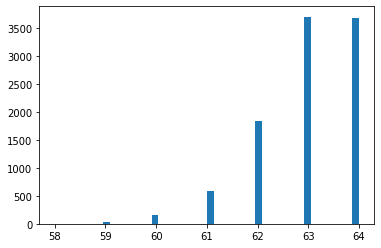

In [6]:
plt.hist([len(perm) for perm in perms], bins='rice')

In [7]:
df = pd.read_csv('../../sparse-dsft-cpp-tierry/data/bitcount_1_GCC_64_1000.csv')

In [8]:
df = df.replace([np.nan], -1)

(array([  2.,   0.,   0.,   0.,  13.,   0.,   0.,   0.,  62.,   0.,   0.,
          0., 185.,   0.,   0.,   0., 353.,   0.,   0., 385.]),
 array([59.  , 59.25, 59.5 , 59.75, 60.  , 60.25, 60.5 , 60.75, 61.  ,
        61.25, 61.5 , 61.75, 62.  , 62.25, 62.5 , 62.75, 63.  , 63.25,
        63.5 , 63.75, 64.  ]),
 <BarContainer object of 20 artists>)

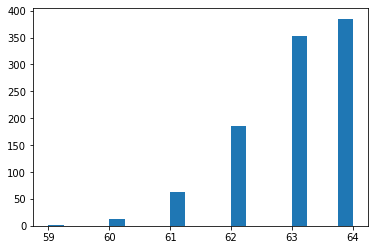

In [9]:
plt.hist((df.to_numpy()[:, 1:] != -1).sum(axis=1), bins='rice')

In [10]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
import torch

In [11]:
class OptimizationsDataModule(pl.LightningDataModule):
    def __init__(self, 
                 n_flags=64,
                 batch_size=32, 
                 num_workers=12,
                 seed=42,
                 path='../../sparse-dsft-cpp-tierry/data/bitcount_1_GCC_64_1000.csv',
                 *args,
                 **kwargs):
        """
        Note that 0 is used as padding token, 1,...,64 are the tokens for the flags
        """
        super().__init__()
        self.n_flags = n_flags
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.seed = seed
        self.save_hyperparameters()
        
    def prepare_data(self):
        df = pd.read_csv('../../sparse-dsft-cpp-tierry/data/bitcount_1_GCC_64_1000.csv')
        df = df.replace([np.nan], -1)
        data = df.to_numpy()
        self.sequences = torch.tensor(data[:, 1:], dtype=torch.long) + 1
        labels = data[:,0]
        labels = (labels - labels.mean())/labels.std()
        self.labels = torch.tensor(labels[:, np.newaxis], dtype=torch.float32)
        
    def setup(self, stage=None):
        n = len(self.sequences)
        print(stage)
        dataset = TensorDataset(self.sequences, self.labels)
        self.train, self.valid, self.test = random_split(dataset, [int(0.8*n), int(0.1*n), n - int(0.8*n) - int(0.1*n)], generator=torch.Generator().manual_seed(self.seed))
        
    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.valid, batch_size=self.batch_size, num_workers=self.num_workers)
    
    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, num_workers=self.num_workers)
        
        
        

In [12]:
datamodule = OptimizationsDataModule()

In [13]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
import torchmetrics

In [14]:
class SequenceRegression(pl.LightningModule):
    def __init__(self, 
                 dict_size, 
                 embedding_size, 
                 hidden_size, 
                 num_layers=1, 
                 bias=True, 
                 batch_first=True, 
                 dropout=0, 
                 bidirectional=False,
                 proj_size=0,
                 lr = 1e-3,#5e-5,
                 scores = {'r2': torchmetrics.R2Score()}):
        super().__init__()
        self.embed = nn.Embedding(dict_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, 
                           num_layers=num_layers,
                           bias=bias,
                           batch_first=batch_first,
                           dropout=dropout,
                           bidirectional=bidirectional,
                           proj_size=proj_size)
        self.head = nn.Linear(hidden_size, 1)
        self.scores = nn.ModuleDict(scores)
        self.my_lr_arg = lr
        
    def forward(self, x):
        embedded_sequence = self.embed(x)
        output, (hn, cn) = self.rnn(embedded_sequence)
        return self.head(output.sum(dim=1))
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.my_lr_arg)
        return optimizer 
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        pred = self.forward(x)
        loss = F.mse_loss(pred, y)
        self.log('train_loss', loss)
        for name, score in self.scores.items():
            self.log('train_%s'%name, score(pred, y))
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred = self.forward(x)
        loss = F.mse_loss(pred, y)
        self.log('val_loss', loss)
        for name, score in self.scores.items():
            self.log('valid_%s'%name, score(pred, y))
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        pred = self.forward(x)
        loss = F.mse_loss(pred, y)
        self.log('test_loss', loss)
        for name, score in self.scores.items():
            self.log('test_%s'%name, score(pred, y))

In [15]:
reg = SequenceRegression(65, 256, 256, num_layers=3)

In [16]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

In [17]:
import os
print (os.environ['CONDA_DEFAULT_ENV'])

csss


In [18]:
wandb_logger = WandbLogger(entity='chrisxx', project='cfo_supervised')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: selfsupervised (use `wandb login --relogin` to force relogin)


In [19]:
checkpoint_callback = ModelCheckpoint(dirpath="../checkpoints/", save_top_k=2, monitor="val_loss")

In [20]:
trainer = pl.Trainer(accelerator="gpu", devices=1, max_epochs=100,
                     auto_lr_find='my_lr_arg',
                     callbacks=[checkpoint_callback],
                     logger=wandb_logger)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
#trainer.tune(model=reg, datamodule=datamodule)

In [22]:
trainer.fit(model=reg, datamodule=datamodule)

TrainerFn.FITTING


/home/chrisw/miniconda3/envs/csss/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:608: UserWarning: Checkpoint directory /home/chrisw/Documents/projects/2022/selfsupervisedcs/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | embed  | Embedding  | 16.6 K
1 | rnn    | LSTM       | 1.6 M 
2 | head   | Linear     | 257   
3 | scores | ModuleDict | 0     
--------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.384     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/chrisw/miniconda3/envs/csss/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1938: PossibleUserWarning: The number of training samples (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [23]:
trainer.validate(datamodule=datamodule)

/home/chrisw/miniconda3/envs/csss/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1447: UserWarning: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `validate(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  rank_zero_warn(
Restoring states from the checkpoint path at /home/chrisw/Documents/projects/2022/selfsupervisedcs/checkpoints/epoch=32-step=825.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/chrisw/Documents/projects/2022/selfsupervisedcs/checkpoints/epoch=32-step=825.ckpt


TrainerFn.VALIDATING


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.8161027431488037
        valid_r2            -0.1347905397415161
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.8161027431488037, 'valid_r2': -0.1347905397415161}]

In [24]:
trainer.test(datamodule=datamodule)

/home/chrisw/miniconda3/envs/csss/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1447: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  rank_zero_warn(
Restoring states from the checkpoint path at /home/chrisw/Documents/projects/2022/selfsupervisedcs/checkpoints/epoch=32-step=825.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/chrisw/Documents/projects/2022/selfsupervisedcs/checkpoints/epoch=32-step=825.ckpt


TrainerFn.TESTING


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8282470107078552
         test_r2           -0.44866108894348145
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.8282470107078552, 'test_r2': -0.44866108894348145}]